In [33]:
import numpy as np
import os
import cv2
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Conv2DTranspose
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam

mixed_precision.set_global_policy('mixed_float16')

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [76]:
def load_and_stack_as_rgb(brain_bone_path, brain_path, subdural_path):
    """
    Reads three grayscale images and combines them into an RGB image.

    - brain_bone_window → Red channel
    - brain_window → Green channel
    - subdural_window → Blue channel

    Returns a (H, W, 3) RGB image.
    """
    # Load grayscale images
    brain_bone = cv2.imread(brain_bone_path, cv2.IMREAD_GRAYSCALE)
    brain = cv2.imread(brain_path, cv2.IMREAD_GRAYSCALE)
    subdural = cv2.imread(subdural_path, cv2.IMREAD_GRAYSCALE)

    # Ensure all images are the same shape
    if not (brain_bone.shape == brain.shape == subdural.shape):
        raise ValueError("Input images do not have same size")

    if not (brain_bone.shape == (512, 512)):
        print("\nbrain_bone.shape = ", brain_bone.shape, "\tbrain.shape = ", brain.shape, "\tsubdural.shape = ",
              subdural.shape)
        print("Path = ", brain_bone_path)

    # Normalize pixel values to [0,1] (optional, but recommended)
    brain_bone = brain_bone / 255.0
    brain = brain / 255.0
    subdural = subdural / 255.0

    # Stack images into an RGB format
    rgb_image = np.stack([brain_bone, brain, subdural], axis=-1)

    # Convert back to 0-255 and uint8 for visualization/saving
    # rgb_image = (rgb_image * 255).astype(np.uint8)

    return rgb_image


def find_matching_image_paths(bone_folder, brain_folder, subdural_folder, mask_folder):
    """
    Walks through the subfolders and finds images with the same filename across all three directories.

    Returns a list of tuples containing matching image paths from each folder.
    """
    # Get the list of all image filenames in each directory
    bone_images = set(os.listdir(bone_folder))
    brain_images = set(os.listdir(brain_folder))
    subdural_images = set(os.listdir(subdural_folder))
    mask_images = set(os.listdir(mask_folder))

    # Find common filenames across all three folders
    common_files = bone_images.intersection(brain_images).intersection(subdural_images).intersection(mask_images)

    # Create a list of tuples with paths to the matching images
    matching_image_paths = []
    for filename in common_files:
        bone_path = os.path.join(bone_folder, filename)
        brain_path = os.path.join(brain_folder, filename)
        subdural_path = os.path.join(subdural_folder, filename)
        mask_path = os.path.join(mask_folder, filename)
        matching_image_paths.append((bone_path, brain_path, subdural_path, mask_path))

    return matching_image_paths


def build_unet(input_shape):
    """
    Simplified U-Net model for brain hemorrhage segmentation.
    Reduced complexity for faster training.
    """
    # inputs = keras.Input(shape=input_shape)
    inputs = keras.Input(shape=input_shape, name="image_input")

    # Encoder - fewer filters, one less level
    c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)  # 256x256

    c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)  # 128x128

    # Bridge - fewer filters
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)

    # Decoder - fewer filters, one less level
    u4 = Conv2D(16, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c3))  # 256x256
    u4 = tf.keras.layers.concatenate([u4, c2])
    c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)

    u5 = Conv2D(8, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c4))  # 512x512
    u5 = tf.keras.layers.concatenate([u5, c1])
    c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(outputs)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def build_medium_unet(input_shape):
    """
    Larger U-Net model
    """
    inputs = keras.Input(shape=input_shape, name="image_input")

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    # Decoder
    u5 = Conv2D(64, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c4))
    u5 = tf.keras.layers.concatenate([u5, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2D(32, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c5))
    u6 = tf.keras.layers.concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2D(16, (2, 2), activation='relu', padding='same')(tf.keras.layers.UpSampling2D((2, 2))(c6))
    u7 = tf.keras.layers.concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(outputs)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def build_enhanced_unet(input_shape):
    """
    Enhanced U-Net model with:
    - Larger convolution kernels (5x5, 7x7) at strategic layers
    - Optimized skip connections
    - Dropout for regularization
    """
    inputs = keras.Input(shape=input_shape, name="image_input")

    # Encoder
    # First level with 3x3 convolutions
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Second level with 5x5 convolution for increased receptive field
    c2 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Third level with 5x5 convolution
    c3 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = Dropout(0.2)(c3)  # Adding dropout for regularization
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    # Using 7x7 convolution at the bottleneck for maximum receptive field
    c4 = Conv2D(128, (7, 7), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = Dropout(0.3)(c4)  # Higher dropout rate at the bottleneck

    # Decoder with optimized skip connections
    # First upsampling
    u5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c4)
    # Explicit copy and crop (already handled by concatenate)
    u5 = tf.keras.layers.concatenate([u5, c3])  # Skip connection from encoder
    c5 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Second upsampling
    u6 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c5)
    # Explicit copy and crop (already handled by concatenate)
    u6 = tf.keras.layers.concatenate([u6, c2])  # Skip connection from encoder
    c6 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Third upsampling
    u7 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c6)
    # Explicit copy and crop (already handled by concatenate)
    u7 = tf.keras.layers.concatenate([u7, c1])  # Skip connection from encoder
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(outputs)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def show_predictions_dyn(model, dataset, num_batches=1,num_in_batch=5):
    for batch in range(num_batches):
        for images, masks in dataset.take(batch):
            preds = model.predict(images)

            for i in range(num_in_batch):
                image = images[i]
                true_mask = masks[i]
                pred_mask = preds[i]

                # Threshold predicted mask for display
                pred_mask = tf.where(pred_mask > 0.5, 1.0, 0.0)

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(image.numpy())
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("True Mask")
                plt.imshow(tf.squeeze(true_mask), cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title("Predicted Mask")
                plt.imshow(tf.squeeze(pred_mask), cmap='gray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

def show_predictions_dyn_var(model, dataset, num_batches=1,num_in_batch=5, threshold=0.5):
    for batch in range(num_batches):
        for images, masks in dataset.take(batch):
            preds = model.predict(images)

            for i in range(num_in_batch):
                image = images[i]
                true_mask = masks[i]
                pred_mask = preds[i]

                print(np.unique(pred_mask))
                print(np.unique(true_mask))

                # Threshold predicted mask for display
                pred_mask_bin = tf.where(pred_mask > threshold, 1.0, 0.0)

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 4, 1)
                plt.title("Original Image")
                plt.imshow(image.numpy())
                plt.axis('off')

                plt.subplot(1, 4, 2)
                plt.title("True Mask")
                plt.imshow(tf.squeeze(true_mask), cmap='gray')
                plt.axis('off')

                plt.subplot(1, 4, 3)
                plt.title("Predicted Mask")
                plt.imshow(tf.squeeze(pred_mask), cmap='gray')
                plt.axis('off')

                plt.subplot(1, 4, 4)
                plt.title("Binary Predicted Mask")
                plt.imshow(tf.squeeze(pred_mask_bin), cmap='gray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

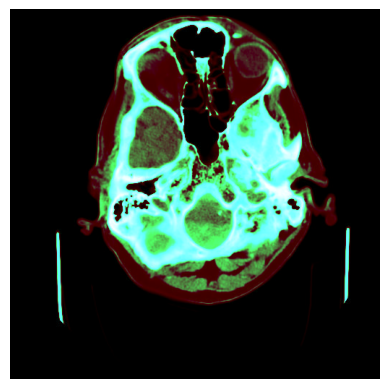

(512, 512, 3)

In [20]:
# Example usage
brain_bone_path = "C:/Users/brode/OneDrive - Northeastern University/Desktop (Old)/Machine Learning/Final Project/XN_Project 1/Hemorrhage3000/brain_bone_window/ID_0a1a010bf.jpg"
brain_path = "C:/Users/brode/OneDrive - Northeastern University/Desktop (Old)/Machine Learning/Final Project/XN_Project 1/Hemorrhage3000/brain_window/ID_0a1a010bf.jpg"
subdural_path = "C:/Users/brode/OneDrive - Northeastern University/Desktop (Old)/Machine Learning/Final Project/XN_Project 1/Hemorrhage3000/subdural_window/ID_0a1a010bf.jpg"

rgb_image = load_and_stack_as_rgb(brain_bone_path, brain_path, subdural_path)

plt.imshow(rgb_image)
plt.axis("off")
plt.show()

rgb_image.shape

In [5]:
bone_folder = 'Hemorrhage3000/brain_bone_window'
brain_folder = 'Hemorrhage3000/brain_window'
subdural_folder = 'Hemorrhage3000/subdural_window'

mask_folder = 'Hemorrhage3000/MasksData/bi-masks'
# mask_folder = 'Hemorrhage3000/MasksData/qu-masks'

matching_paths = find_matching_image_paths(bone_folder, brain_folder, subdural_folder, mask_folder)

In [62]:
brain_img = []
mask_img = []

for paths in matching_paths:
    rgb_image = load_and_stack_as_rgb(paths[0], paths[1], paths[2])
    mask_image = cv2.imread(paths[3], cv2.IMREAD_GRAYSCALE)
    mask_image = mask_image / 255.0

    # Debugging step: Check unique values in mask before thresholding
    print(f"Before thresholding, unique values: {np.unique(mask_image)}")

    # Convert to binary mask (0 for background, 1 for objects)
    mask_image = (mask_image > 0).astype(np.float32)

    # Debugging step: Check unique values in mask after thresholding
    print(f"After thresholding, unique values: {np.unique(mask_image)}")

    if (mask_image.shape == (512, 512)) & (rgb_image.shape == (512, 512, 3)):
        brain_img.append(np.array(rgb_image))
        mask_img.append(np.array(mask_image))

print(len(brain_img))
print(brain_img[0].shape)

print(len(mask_img))
print(mask_img[0].shape)

Before thresholding, unique values: [0.         0.00392157 0.00784314 0.01176471 0.01568627 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.0745098  0.07843137 0.08235294 0.09019608 0.09411765
 0.09803922 0.10980392 0.11372549 0.11764706 0.1254902  0.12941176
 0.86666667 0.87843137 0.89803922 0.90588235 0.91372549 0.91764706
 0.92156863 0.92941176 0.93333333 0.9372549  0.94117647 0.94509804
 0.94901961 0.95294118 0.95686275 0.96078431 0.96470588 0.96862745
 0.97254902 0.97647059 0.98039216 0.98431373 0.98823529 0.99215686
 0.99607843 1.        ]
After thresholding, unique values: [0. 1.]
Before thresholding, unique values: [0.         0.00392157 0.00784314 0.01176471 0.01568627 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.0745098  0.07843137 0.08235294 0.08627451 0

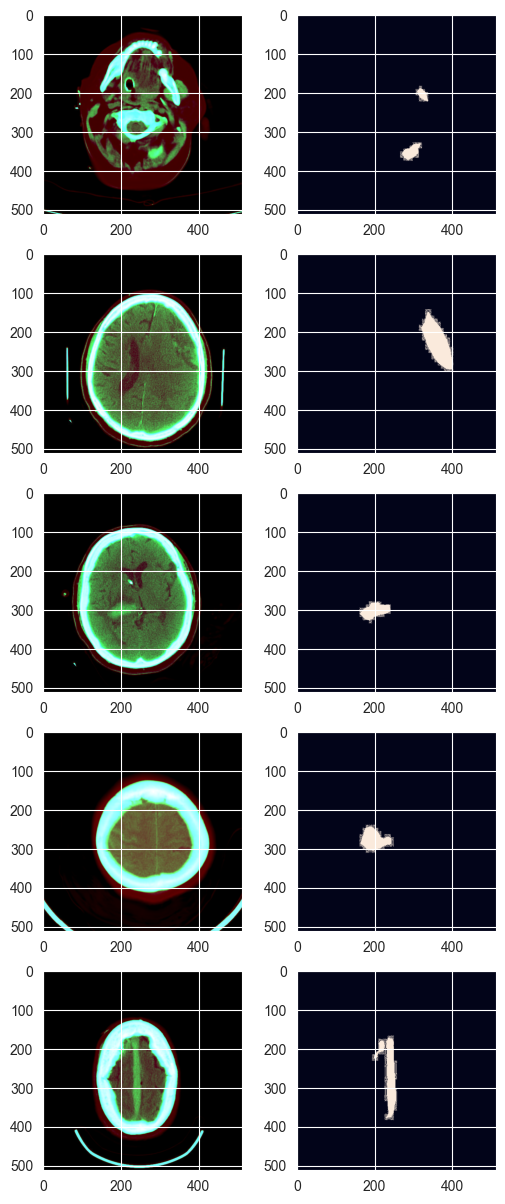

In [63]:
num_to_disp = 5

plt.figure(figsize=(6, 3*num_to_disp))
for index in range(num_to_disp):
    plt.subplot(num_to_disp, 2, index*2+1)
    plt.imshow(brain_img[index])
    plt.axis("on")

    plt.subplot(num_to_disp, 2, index*2+2)
    plt.imshow(mask_img[index])
    plt.axis("on")

plt.show()

In [64]:
# Create a dataset from indices instead of the actual images
train_percentage = 0.8
validate_percentage = 0.1
test_percentage = 0.1

indices_dataset = tf.data.Dataset.from_tensor_slices(np.arange(len(brain_img)))
indices_dataset = indices_dataset.shuffle(buffer_size=len(brain_img))

# Function to load a single image pair by index
def load_image_mask_pair(idx):
    brain = tf.convert_to_tensor(brain_img[idx.numpy()], dtype=tf.float32)
    mask = tf.convert_to_tensor(mask_img[idx.numpy()], dtype=tf.float32)
    return brain, mask

# Modify your dataset mapping function
def tf_load_pair(idx):
    brain, mask = tf.py_function(
        load_image_mask_pair, [idx], [tf.float32, tf.float32]
    )
    brain.set_shape([512, 512, 3])
    mask.set_shape([512, 512])
    # Expand dimensions to add channel dimension for the mask
    mask = tf.expand_dims(mask, axis=-1)
    return brain, mask

# Apply the loading function to create the final dataset
dataset = indices_dataset.map(tf_load_pair)

# Split into train, validation, and test
train_size = int(train_percentage * len(brain_img))
val_size = int(validate_percentage * len(brain_img))

train_dataset = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

# Batch the datasets
BATCH_SIZE = 2  # Try smaller batch size if memory is still an issue
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Images shape: (2, 512, 512, 3)
Masks shape: (2, 512, 512, 1)
Unique values in masks: [0. 1.]
[0. 1.]


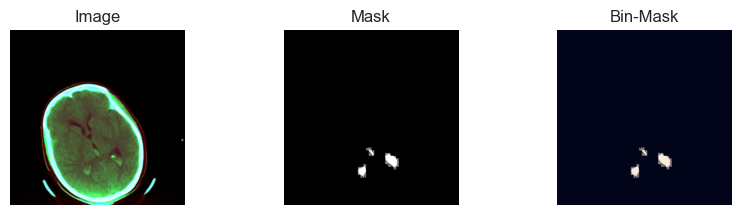

[0. 1.]


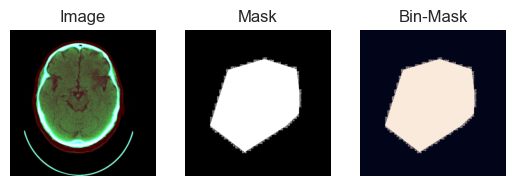

In [67]:
# Check if the dataset is working
for images, masks in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Masks shape:", masks.shape)
    print("Unique values in masks:", np.unique(masks.numpy()))

    # Visualize a few examples
    disp_num = 2
    plt.figure(figsize=(10, 5))
    for i in range(min(disp_num, images.shape[0])):
        mask_im = masks[i].numpy()
        print(np.unique(mask_im))
        binary_im = (masks[i].numpy() > 0.5).astype(np.float32)

        plt.subplot(disp_num, 3, i*3+1)
        plt.imshow(images[i].numpy())
        plt.title("Image")
        plt.axis("off")

        plt.subplot(disp_num, 3, i*3+2)
        plt.imshow(masks[i].numpy(), cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(disp_num, 3, i*3+3)
        plt.imshow(binary_im)
        plt.title("Bin-Mask")
        plt.axis("off")
        plt.show()


In [69]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model10 = build_unet(input_shape)

# Compile the model10
model10.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model10
# model10.summary()

# Train the model10
history = model10.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model10.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5008 - loss: 0.9705 - precision: 0.0264 - recall: 0.9872

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 224s 190ms/step - accuracy: 0.5009 - loss: 0.9705 - precision: 0.0264 - recall: 0.9872 - val_accuracy: 0.7172 - val_loss: 0.9664 - val_precision: 0.0445 - val_recall: 0.9770 - learning_rate: 0.0010
Epoch 2/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 209s 180ms/step - accuracy: 0.7127 - loss: 0.9685 - precision: 0.0413 - recall: 0.9858 - val_accuracy: 0.7091 - val_loss: 0.9671 - val_precision: 0.0426 - val_recall: 0.9833 - learning_rate: 0.0010
Epoch 3/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7170 - loss: 0.9674 - precision: 0.0431 - recall: 0.9818

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 210s 181ms/step - accuracy: 0.7170 - loss: 0.9674 - precision: 0.0431 - recall: 0.9818 - val_accuracy: 0.7671 - val_loss: 0.9636 - val_precision: 0.0581 - val_recall: 0.9589 - learning_rate: 0.0010
Epoch 4/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 209s 180ms/step - accuracy: 0.7717 - loss: 0.9682 - precision: 0.0503 - recall: 0.9515 - val_accuracy: 0.7812 - val_loss: 0.9693 - val_precision: 0.0508 - val_recall: 0.9652 - learning_rate: 0.0010
Epoch 5/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 230s 198ms/step - accuracy: 0.7799 - loss: 0.9668 - precision: 0.0548 - recall: 0.9540 - val_accuracy: 0.7753 - val_loss: 0.9653 - val_precision: 0.0567 - val_recall: 0.9625 - learning_rate: 0.0010


In [70]:
model10.load_weights('best_model10.h5')
test_loss, test_acc, test_prec, test_recall = model10.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 60s 83ms/step - accuracy: 0.7616 - loss: 0.9676 - precision: 0.0502 - recall: 0.9765
Test Accuracy: 0.7647, Precision: 0.0523, Recall: 0.9618


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


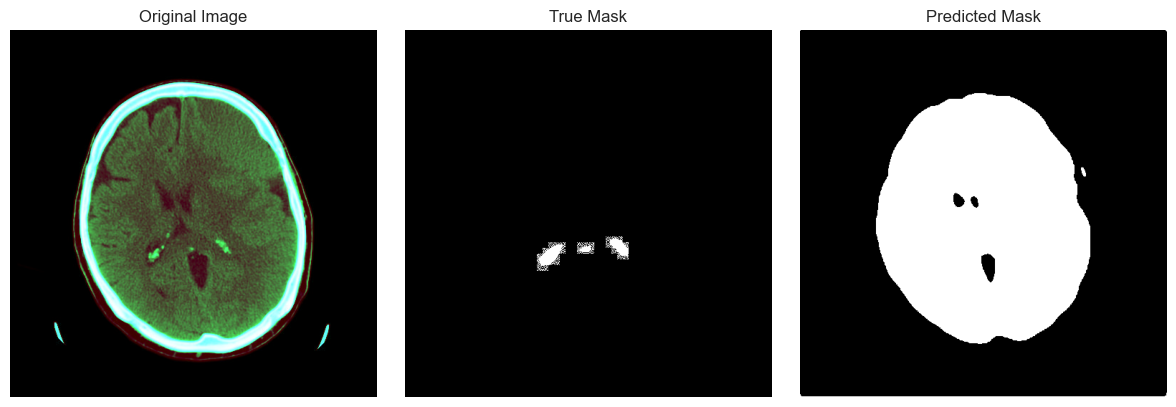

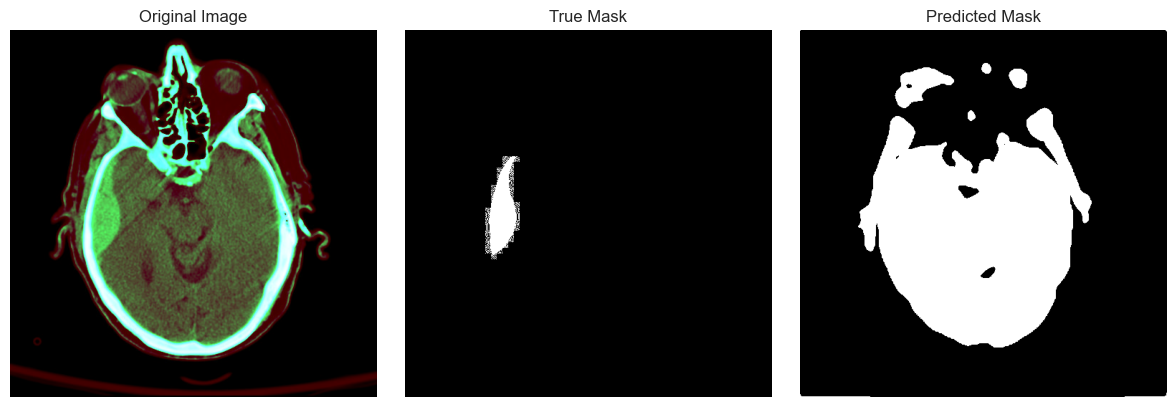

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


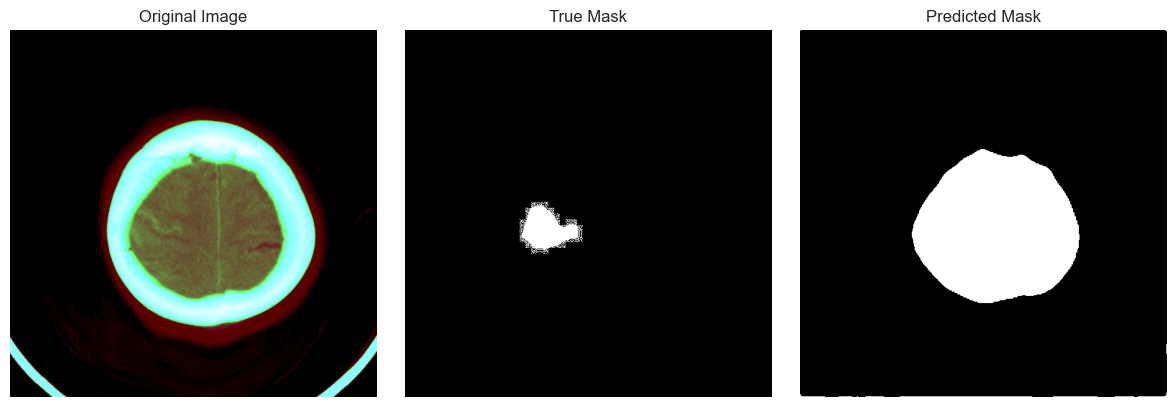

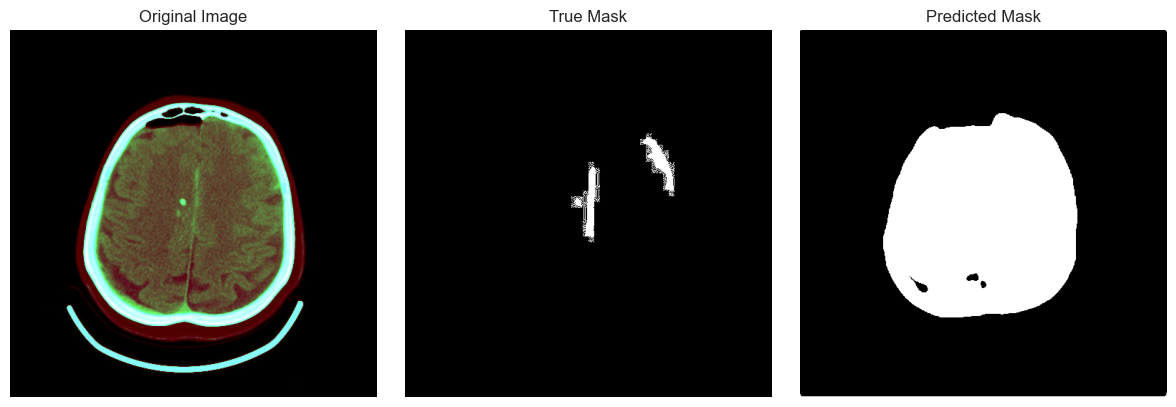

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


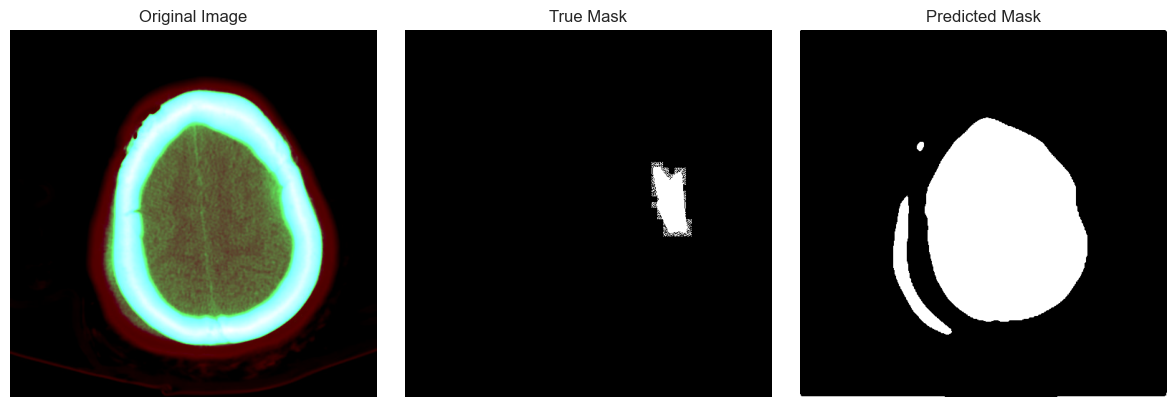

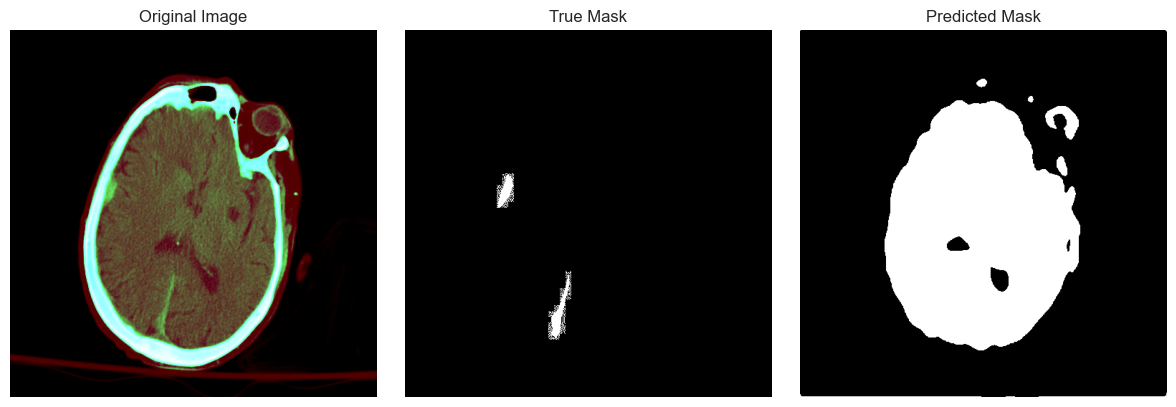

In [71]:
show_predictions_dyn(model10, test_dataset, num_batches=3, num_in_batch=2)

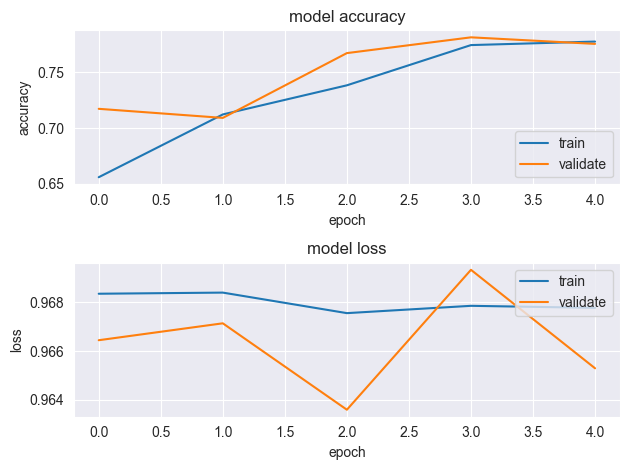

In [72]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [19]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model11 = build_unet(input_shape)

# Compile the model11
model11.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model11
# model11.summary()

# Train the model11
history = model11.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model11.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1827 - loss: 0.9756 - precision_2: 0.0144 - recall_2: 0.9446

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 238s 202ms/step - accuracy: 0.1828 - loss: 0.9756 - precision_2: 0.0144 - recall_2: 0.9446 - val_accuracy: 0.2659 - val_loss: 0.9740 - val_precision_2: 0.0151 - val_recall_2: 0.8965 - learning_rate: 0.0010
Epoch 2/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5813 - loss: 0.9735 - precision_2: 0.0298 - recall_2: 0.9112

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 219s 189ms/step - accuracy: 0.5814 - loss: 0.9735 - precision_2: 0.0298 - recall_2: 0.9112 - val_accuracy: 0.8341 - val_loss: 0.9721 - val_precision_2: 0.0682 - val_recall_2: 0.8816 - learning_rate: 0.0010
Epoch 3/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 220s 189ms/step - accuracy: 0.6857 - loss: 0.9720 - precision_2: 0.0413 - recall_2: 0.9219 - val_accuracy: 0.8377 - val_loss: 0.9738 - val_precision_2: 0.0641 - val_recall_2: 0.8574 - learning_rate: 0.0010
Epoch 4/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 217s 187ms/step - accuracy: 0.6727 - loss: 0.9744 - precision_2: 0.0354 - recall_2: 0.9319 - val_accuracy: 0.8068 - val_loss: 0.9739 - val_precision_2: 0.0576 - val_recall_2: 0.9209 - learning_rate: 0.0010
Epoch 5/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 213s 184ms/step - accuracy: 0.7927 - loss: 0.9720 - precision_2: 0.0581 - recall_2: 0.9078 - val_accuracy: 0.7815 - val_loss: 0.9742 - val_precision_2: 0.0521 - val_recall_2: 0.9473 - learning_rate: 0.0010


In [42]:
model11.load_weights('best_model11.h5')
test_loss, test_acc, test_prec, test_recall = model11.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - accuracy: 0.8416 - loss: 0.9757 - precision_2: 0.0635 - recall_2: 0.8929
Test Accuracy: 0.8419, Precision: 0.0684, Recall: 0.8821


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
[0.5        0.50000006 0.5000001  0.5000002  0.50000024 0.5000003
 0.50000036 0.5000004  0.5000005  0.5000006  0.50000066 0.5000007
 0.50000083 0.50000095 0.500001   0.5000011  0.5000012  0.50000125
 0.50000143 0.5000015  0.50000167 0.5000018  0.50000185 0.5000019
 0.50000197 0.500002   0.50000215 0.50000226 0.5000024  0.50000244
 0.5000025  0.50000256 0.50000286 0.5000029  0.50000316 0.5000033
 0.50000334 0.5000034  0.50000346 0.5000035  0.5000036  0.50000364
 0.5000037  0.5000038  0.50000393 0.50000405 0.50000423 0.5000044
 0.5000045  0.50000453 0.5000046  0.50000465 0.5000048  0.5000049
 0.50000495 0.50000507 0.5000051  0.50000536 0.5000061  0.50000614
 0.50000626 0.5000074  0.5000076  0.50000805 0.5000085  0.500009
 0.50000924 0.5000093  0.50000936 0.5000094  0.5000096  0.50000966
 0.5000097  0.5000103  0.5000108  0.50001085 0.5000109  0.50001156
 0.50001204 0.50001246 0.5000127  0.50001276 0.5000131  0.5000139
 0.50001484 0.500015   0.5000154

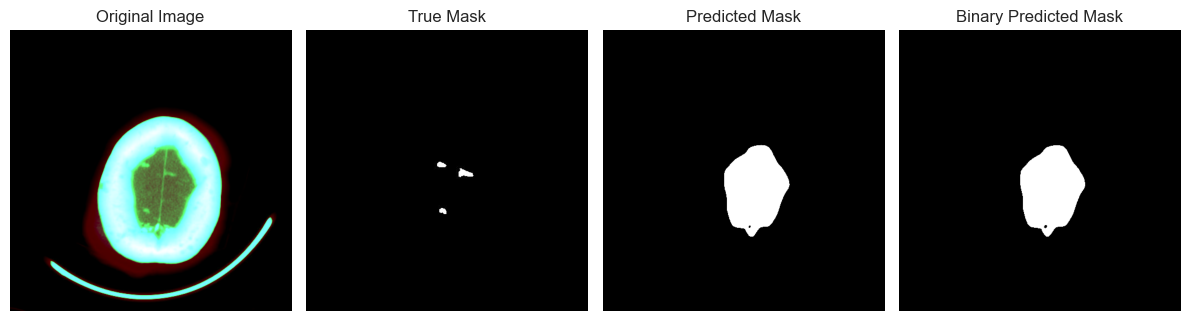

[0.5        0.50000006 0.5000001  ... 0.7310584  0.7310585  0.73105854]
8613
205126
1178


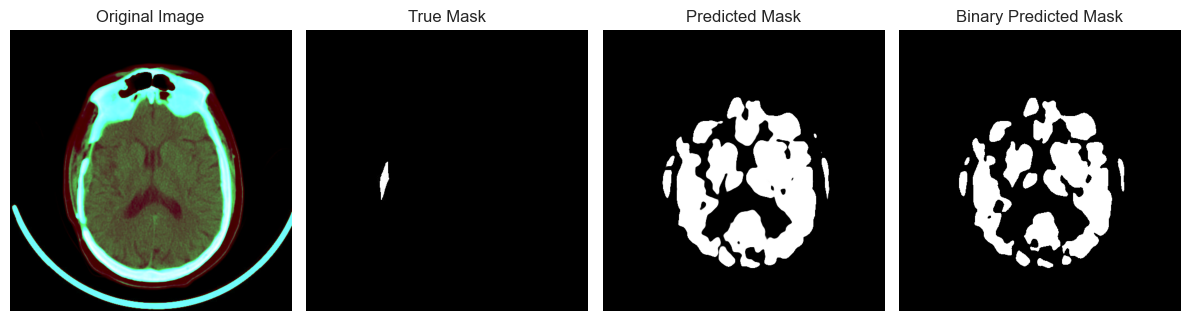

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
[0.5        0.50000006 0.5000001  ... 0.7310584  0.7310585  0.73105854]
7732
196875
930


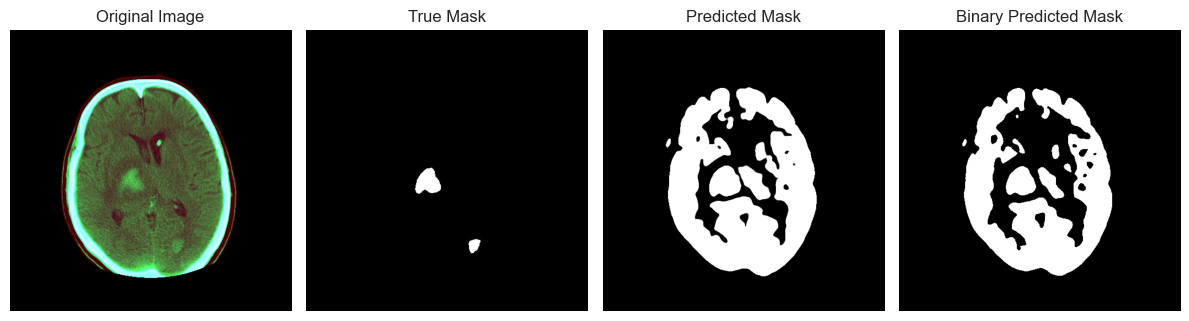

[0.5        0.50000006 0.5000001  ... 0.7310584  0.7310585  0.73105854]
8079
208074
985


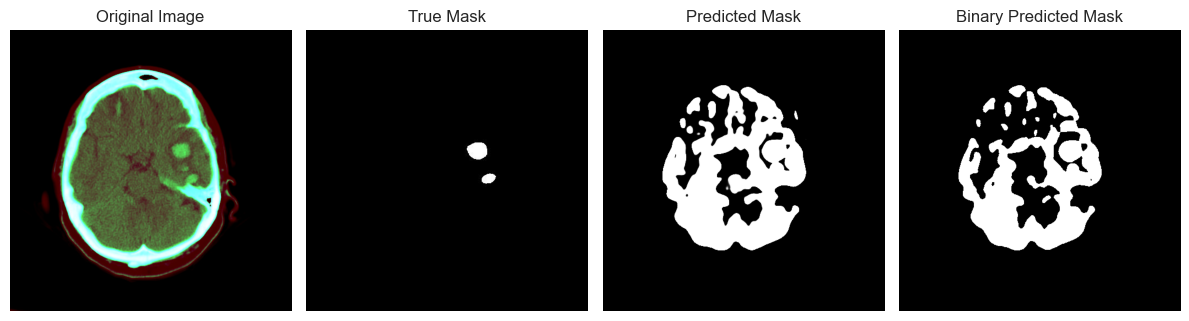

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
[0.5        0.50000006 0.5000001  ... 0.7310584  0.7310585  0.73105854]
5633
204062
869


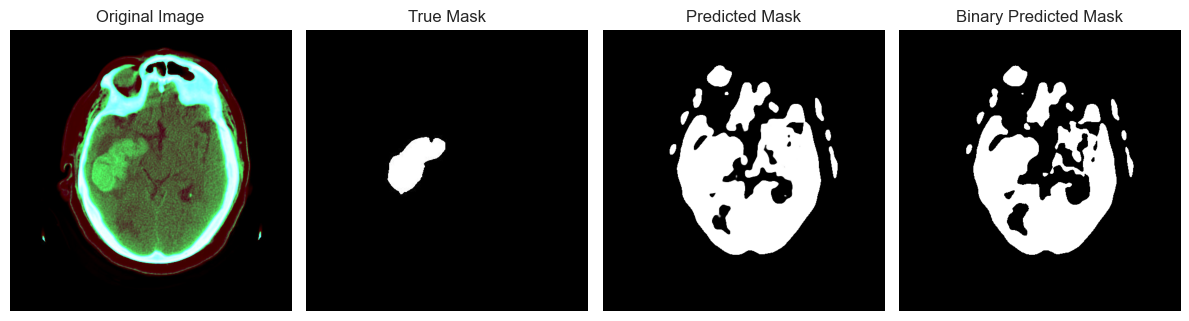

[0.5        0.50000006 0.5000001  ... 0.7310584  0.7310585  0.73105854]
5717
210295
638


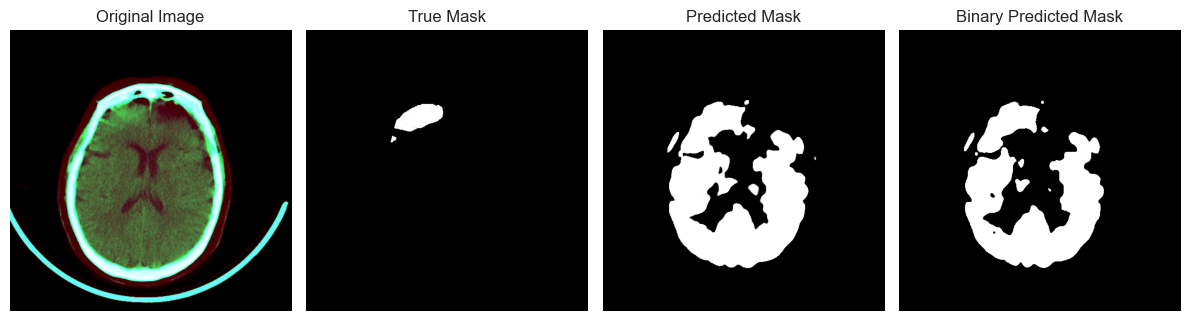

In [59]:
#show_predictions_dyn(model11, test_dataset, num_batches=3, num_in_batch=2)
#show_predictions_dyn_var(model11, test_dataset, num_batches=3, num_in_batch=2,threshold=0.75)
#show_predictions_dyn_var(model11, test_dataset, num_batches=3, num_in_batch=2,threshold=0.625)
#show_predictions_dyn_var(model11, test_dataset, num_batches=3, num_in_batch=2,threshold=0.7)
#show_predictions_dyn_var(model11, test_dataset, num_batches=3, num_in_batch=2,threshold=0.725)
#show_predictions_dyn_var(model11, test_dataset, num_batches=3, num_in_batch=2,threshold=0.731)
#show_predictions_dyn_var(model11, test_dataset, num_batches=3, num_in_batch=2,threshold=0.73105)
show_predictions_dyn_var(model11, test_dataset, num_batches=3, num_in_batch=2,threshold=0.7310585)

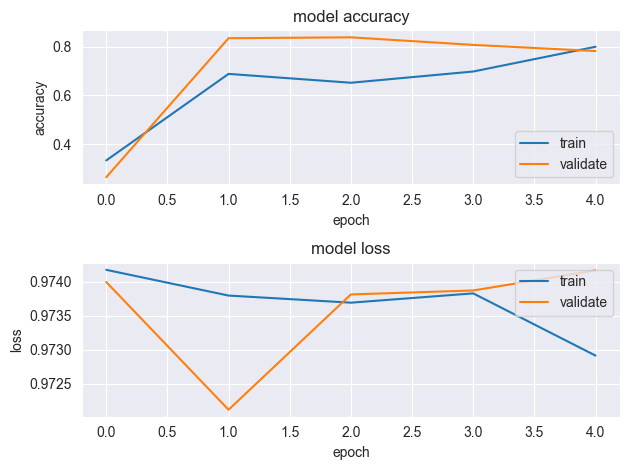

In [22]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [26]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model12 = build_medium_unet(input_shape)

# Compile the model12
model12.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model12
# model12.summary()

# Train the model12
history = model12.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model12.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/15
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.8581 - loss: 0.9794 - precision_3: 0.0139 - recall_3: 0.1416

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 984s 843ms/step - accuracy: 0.8582 - loss: 0.9794 - precision_3: 0.0139 - recall_3: 0.1415 - val_accuracy: 0.9878 - val_loss: 0.9811 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.9872 - loss: 0.9800 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 962s 829ms/step - accuracy: 0.9872 - loss: 0.9800 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9866 - val_loss: 0.9789 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.9869 - loss: 0.9794 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1042s 898ms/step - accuracy: 0.9869 - loss: 0.9794 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9864 - val_loss: 0.9788 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/15
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 993s 856ms/step - accuracy: 0.9871 - loss: 0.9799 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9874 - val_loss: 0.9803 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/15
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 979s 844ms/step - accuracy: 0.9878 - loss: 0.9810 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9872 - val_loss: 0.9800 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/15
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 992s 855ms/step - accuracy: 0.9870 - loss: 0.9797 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9881 - val_loss: 0.9815 - val_precision_3: 0.0000e+00 - val

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1000s 861ms/step - accuracy: 0.9870 - loss: 0.9797 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9865 - val_loss: 0.9787 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/15
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 949s 818ms/step - accuracy: 0.9871 - loss: 0.9798 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9881 - val_loss: 0.9814 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/15
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 952s 821ms/step - accuracy: 0.9873 - loss: 0.9801 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9880 - val_loss: 0.9814 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 10/15
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 949s 817ms/step - accuracy: 0.9871 - loss: 0.9798 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9882 - val_loss: 0.9816 - val_precision_3: 0.0

In [27]:
model12.load_weights('best_model12.h5')
test_loss, test_acc, test_prec, test_recall = model12.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 85s 189ms/step - accuracy: 0.9871 - loss: 0.9799 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Test Accuracy: 0.9868, Precision: 0.0000, Recall: 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


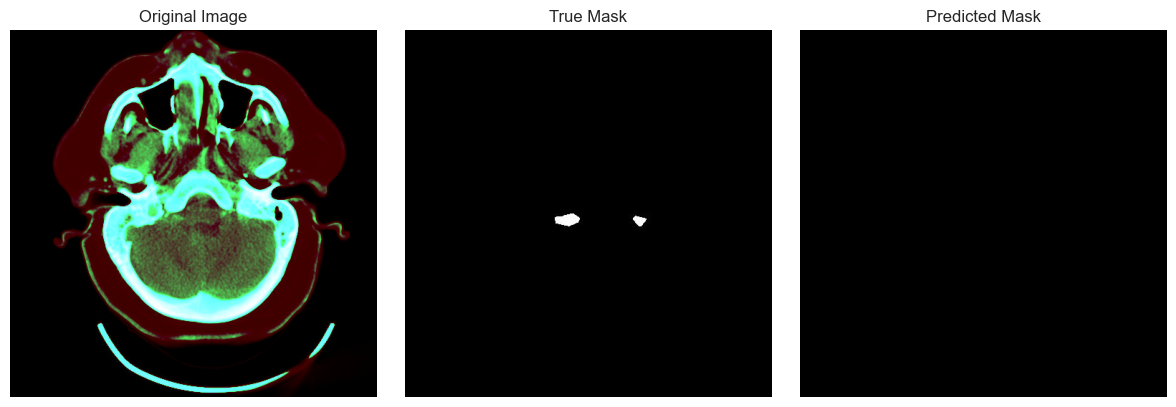

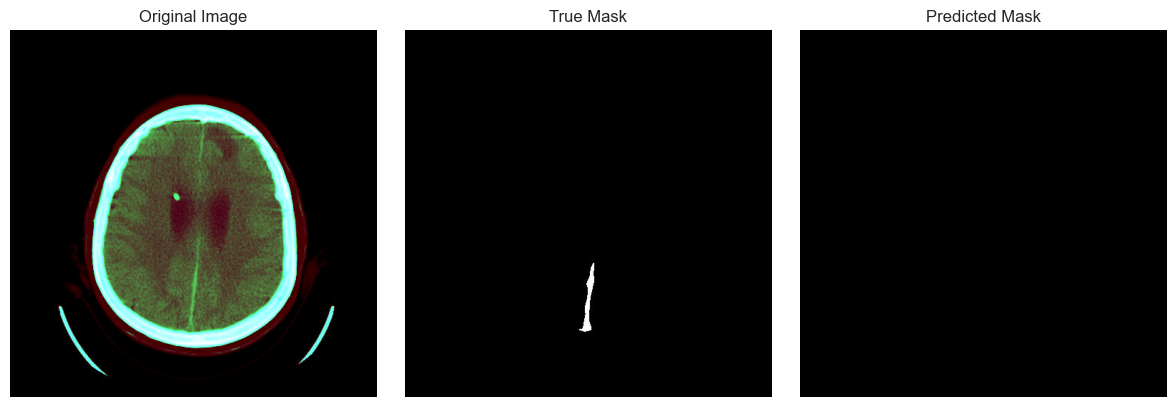

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


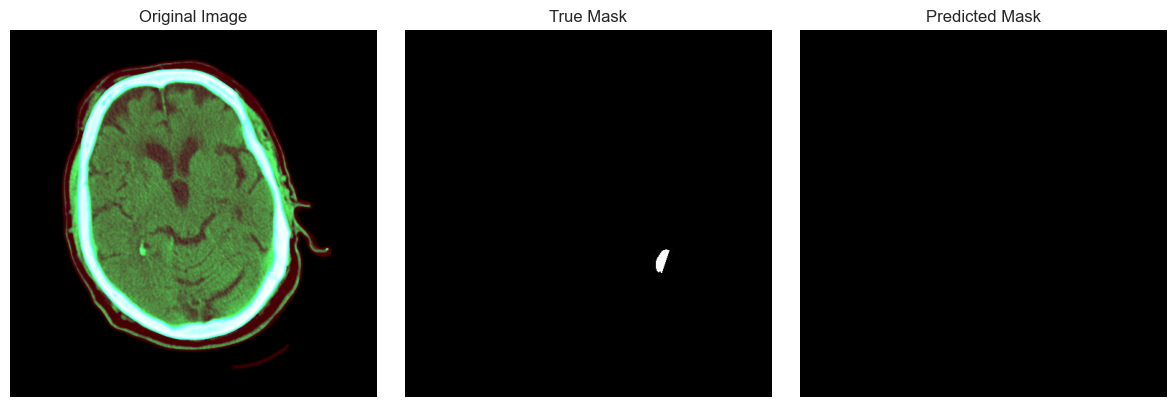

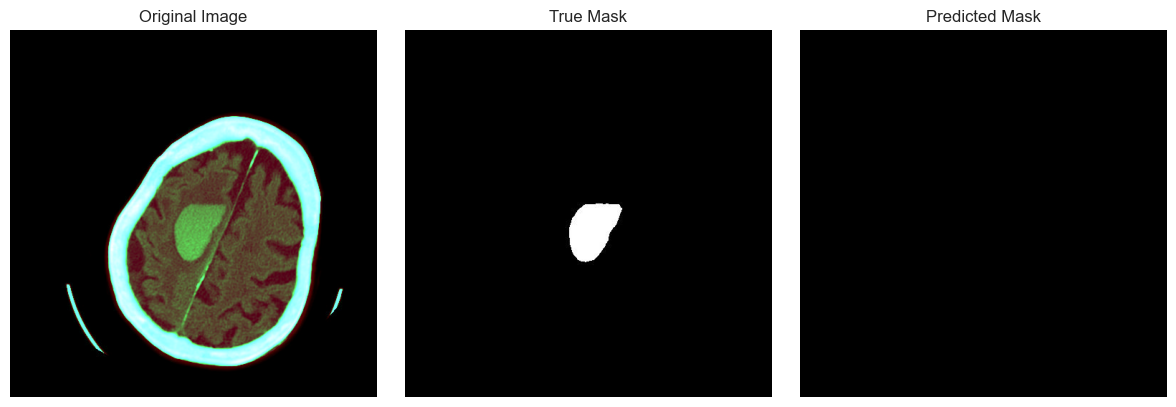

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


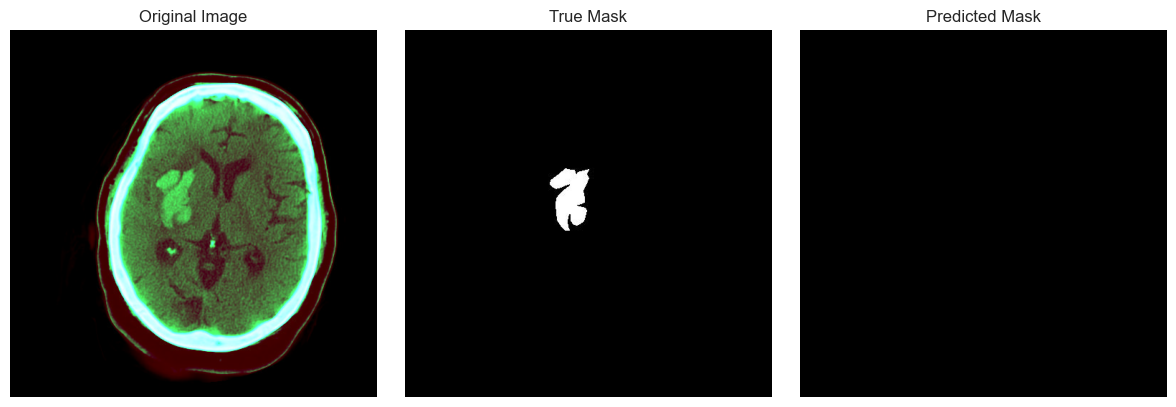

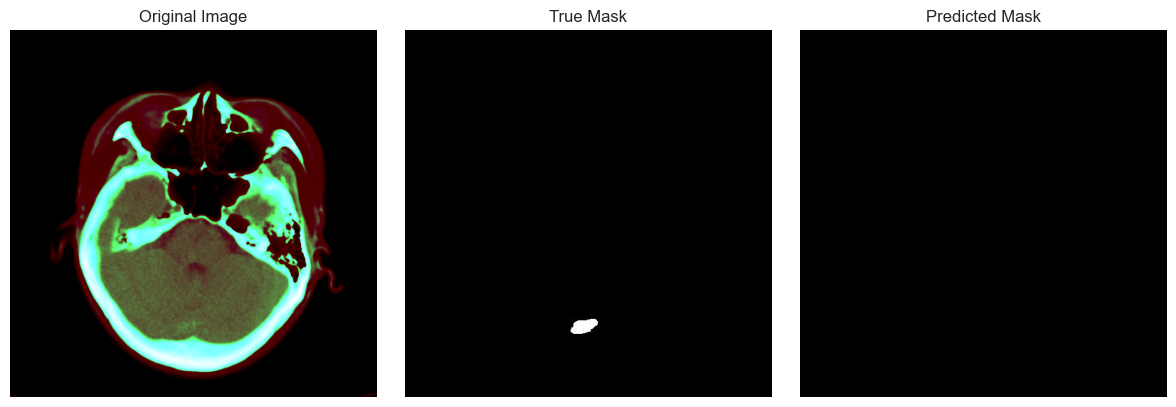

In [28]:
show_predictions_dyn(model12, test_dataset, num_batches=3, num_in_batch=2)

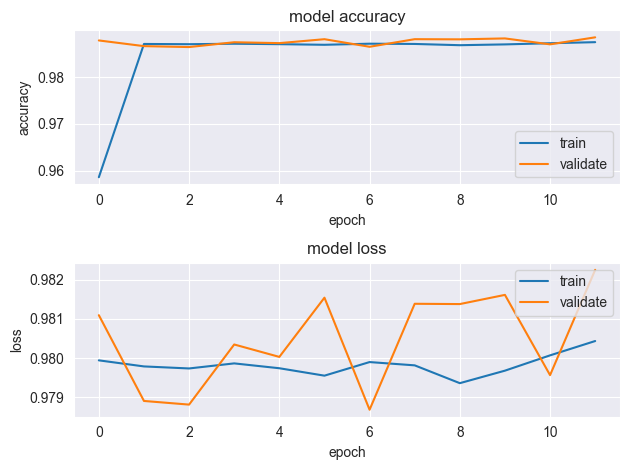

In [29]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [30]:
def weighted_dice_loss(y_true, y_pred):
    smooth = 1e-6

    # Calculate weights based on class frequency
    weight_positive = 1.0 - tf.reduce_mean(y_true)  # Weight for positive pixels
    weight_negative = tf.reduce_mean(y_true)        # Weight for negative pixels

    # Apply weights to each class
    weighted_true = y_true * weight_positive + (1-y_true) * weight_negative
    weighted_pred = y_pred * weight_positive + (1-y_pred) * weight_negative

    # Flatten the tensors
    y_true_f = tf.keras.backend.flatten(weighted_true)
    y_pred_f = tf.keras.backend.flatten(weighted_pred)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [31]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model13 = build_medium_unet(input_shape)

# Compile the model13
model13.compile(
    optimizer='adam',
    loss=weighted_dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model13
# model13.summary()

# Train the model13
history = model13.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model13.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.8895 - loss: 0.9616 - precision_4: 0.0107 - recall_4: 0.0868

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 981s 840ms/step - accuracy: 0.8895 - loss: 0.9616 - precision_4: 0.0107 - recall_4: 0.0867 - val_accuracy: 0.9853 - val_loss: 0.9569 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 971s 837ms/step - accuracy: 0.9867 - loss: 0.9604 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_accuracy: 0.9872 - val_loss: 0.9620 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 983s 847ms/step - accuracy: 0.9871 - loss: 0.9619 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_accuracy: 0.9883 - val_loss: 0.9650 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1009s 870ms/step - accuracy: 0.9868 - loss: 0.9607 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_accuracy: 0.9884 - val_loss: 0.9657 - val_precision_4: 0.0000e+00 - val_recall_4: 

In [32]:
model13.load_weights('best_model13.h5')
test_loss, test_acc, test_prec, test_recall = model13.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 86s 190ms/step - accuracy: 0.9858 - loss: 0.9571 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Test Accuracy: 0.9868, Precision: 0.0000, Recall: 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


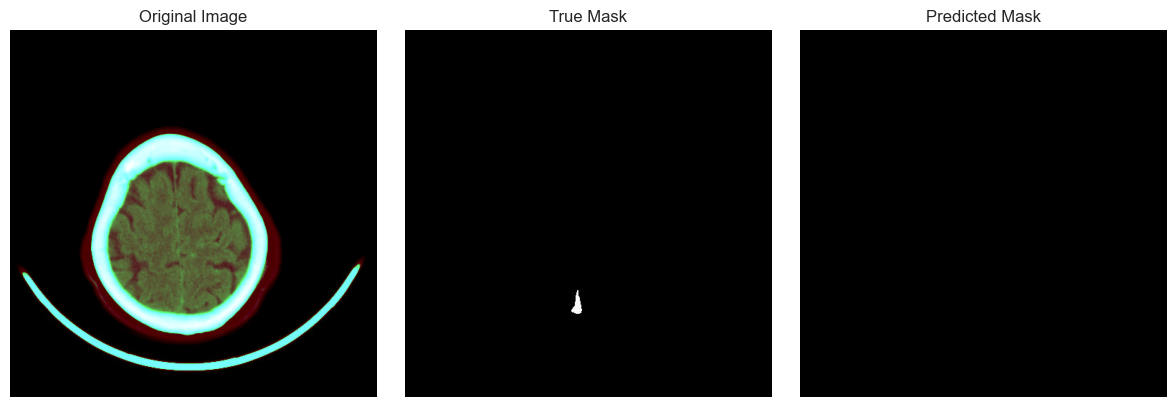

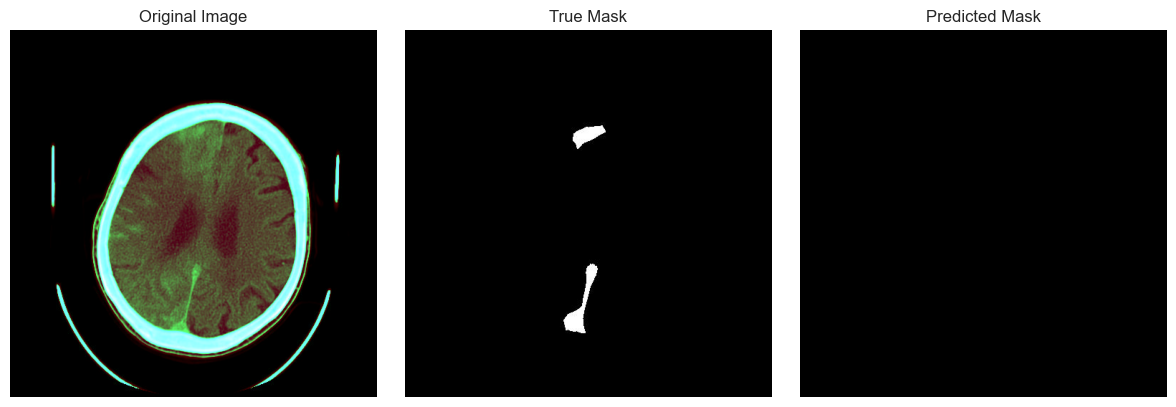

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step


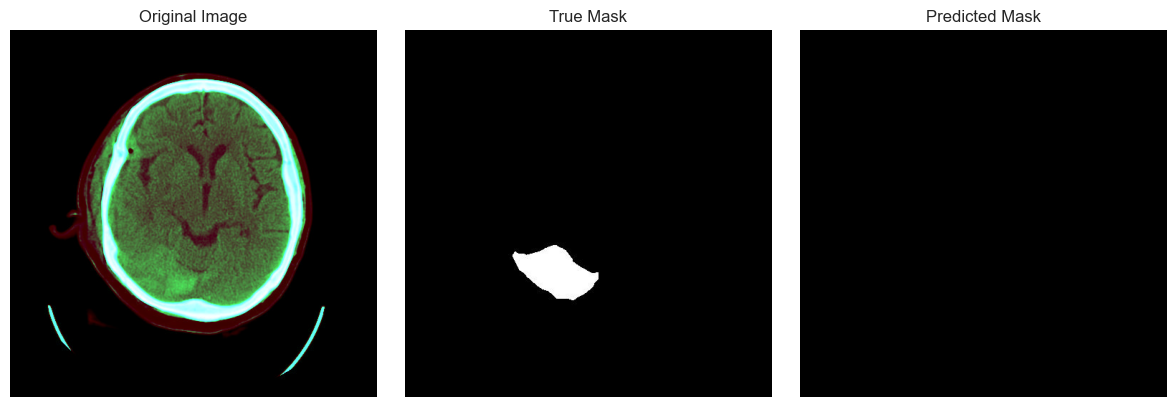

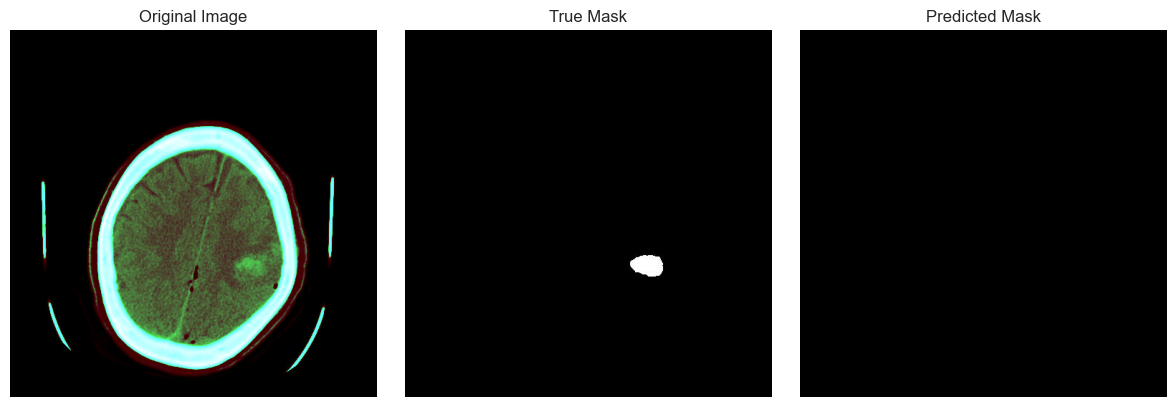

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


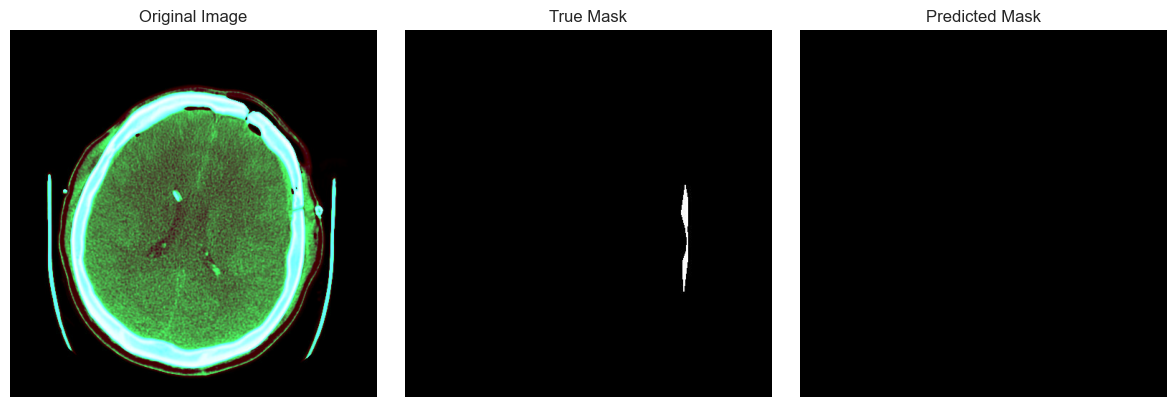

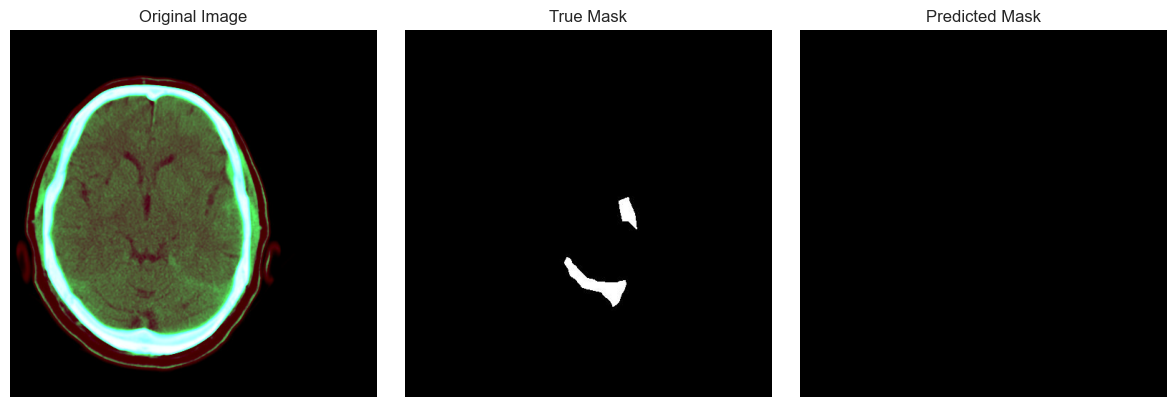

In [33]:
show_predictions_dyn(model13, test_dataset, num_batches=3, num_in_batch=2)

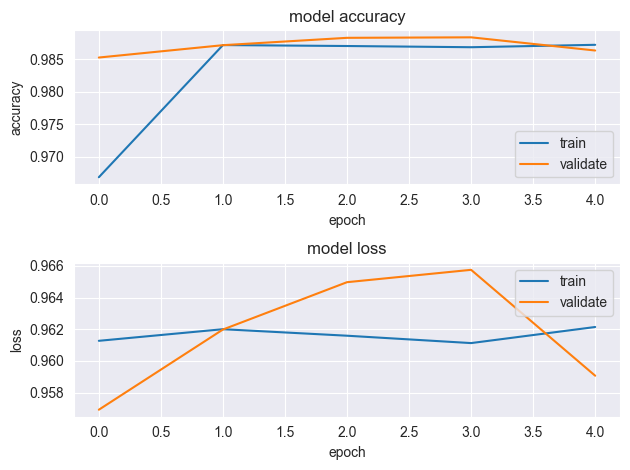

In [34]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


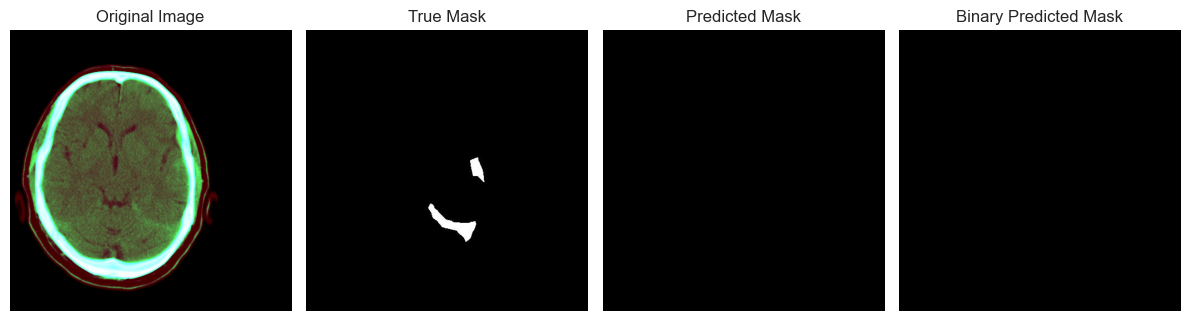

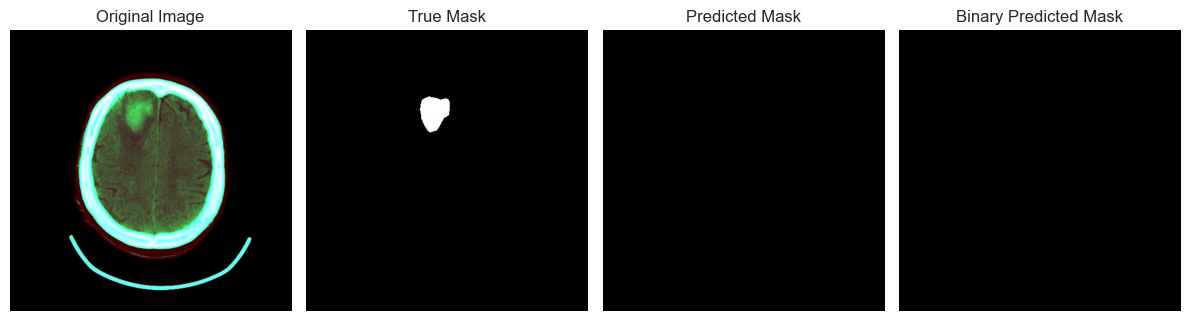

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


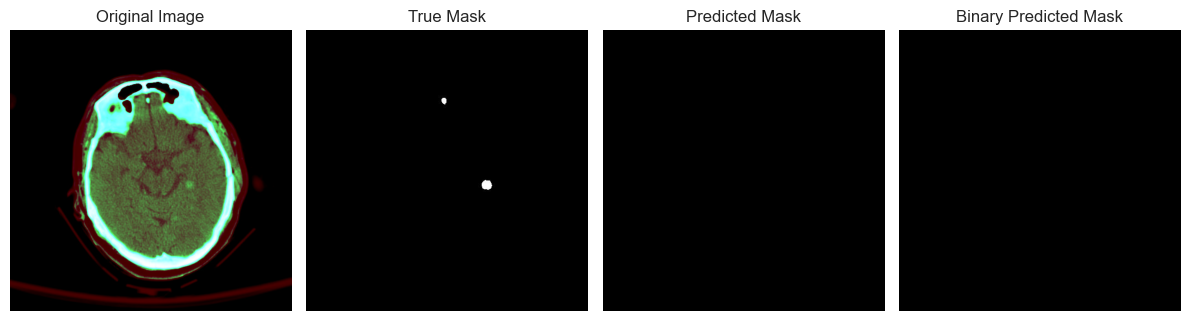

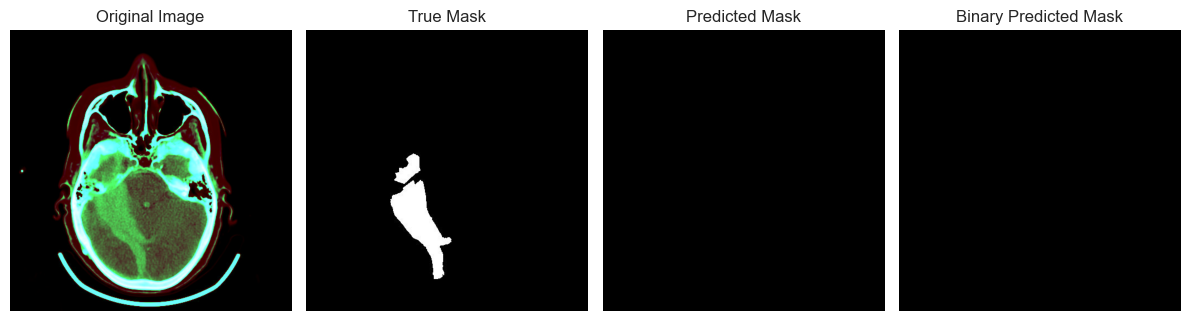

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


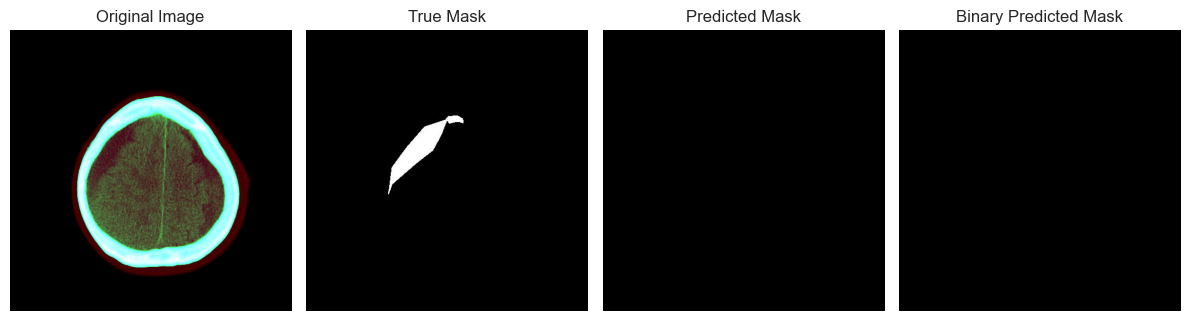

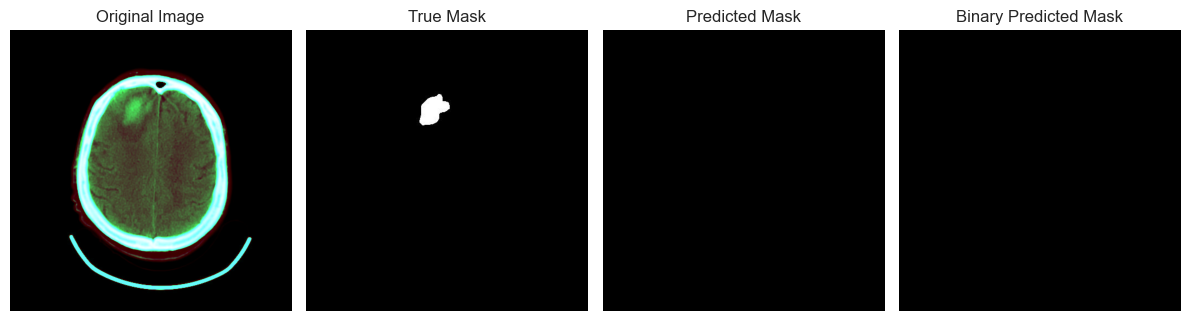

In [41]:
show_predictions_dyn_var(model13, test_dataset, num_batches=3, num_in_batch=2, threshold=0.0)

In [60]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model14 = build_medium_unet(input_shape)

# Compile the model14
model14.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model14
# model14.summary()

# Train the model14
history = model14.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model14.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=25,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.7837 - loss: 0.9778 - precision_5: 0.0303 - recall_5: 0.4339

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 993s 849ms/step - accuracy: 0.7838 - loss: 0.9778 - precision_5: 0.0303 - recall_5: 0.4337 - val_accuracy: 0.9871 - val_loss: 0.9800 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.9874 - loss: 0.9802 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 956s 824ms/step - accuracy: 0.9874 - loss: 0.9802 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9859 - val_loss: 0.9777 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 961s 828ms/step - accuracy: 0.9875 - loss: 0.9805 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9869 - val_loss: 0.9796 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 956s 824ms/step - accuracy: 0.9876 - loss: 0.9806 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9874 - val_loss: 0.9803 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 953s 821ms/step - accuracy: 0.9876 - loss: 0.9806 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9864 - val_loss: 0.9787 - val_precision_5: 0.0000e+00 - val_

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 969s 835ms/step - accuracy: 0.9876 - loss: 0.9806 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9857 - val_loss: 0.9777 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 951s 819ms/step - accuracy: 0.9862 - loss: 0.9784 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9871 - val_loss: 0.9800 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 10/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 958s 826ms/step - accuracy: 0.9874 - loss: 0.9803 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9874 - val_loss: 0.9805 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 11/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.9875 - loss: 0.9807 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 953s 821ms/step - accuracy: 0.9875 - loss: 0.9807 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9851 - val_loss: 0.9767 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 12/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 952s 821ms/step - accuracy: 0.9873 - loss: 0.9801 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9869 - val_loss: 0.9796 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 13/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 952s 821ms/step - accuracy: 0.9871 - loss: 0.9799 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9881 - val_loss: 0.9814 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 14/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 955s 823ms/step - accuracy: 0.9871 - loss: 0.9797 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9879 - val_loss: 0.9810 - val_precision_5: 0.

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 954s 822ms/step - accuracy: 0.9868 - loss: 0.9793 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9848 - val_loss: 0.9762 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 20/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 956s 823ms/step - accuracy: 0.9878 - loss: 0.9810 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9854 - val_loss: 0.9771 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 21/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 958s 825ms/step - accuracy: 0.9875 - loss: 0.9805 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9880 - val_loss: 0.9813 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 22/25
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 959s 826ms/step - accuracy: 0.9872 - loss: 0.9801 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9856 - val_loss: 0.9775 - val_precision_5: 0.

In [61]:
model14.load_weights('best_model14.h5')
test_loss, test_acc, test_prec, test_recall = model14.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 88s 194ms/step - accuracy: 0.9886 - loss: 0.9823 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Test Accuracy: 0.9886, Precision: 0.0000, Recall: 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


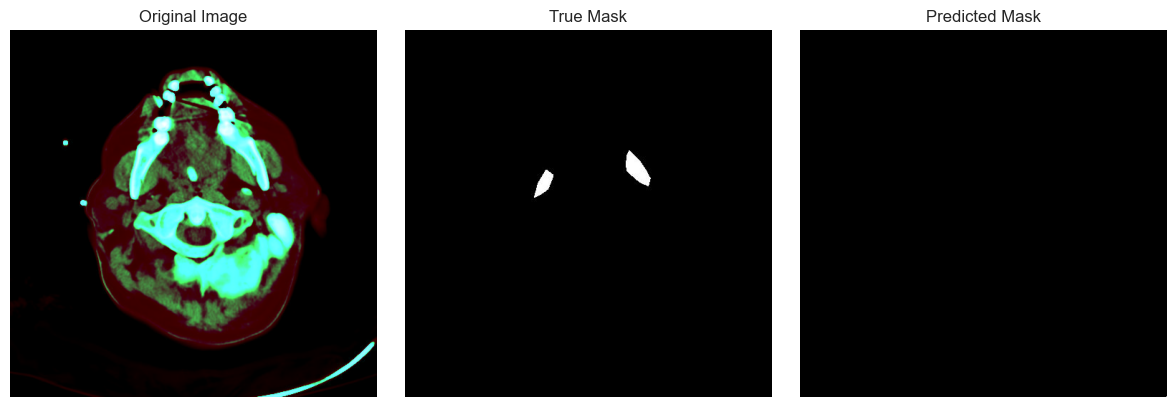

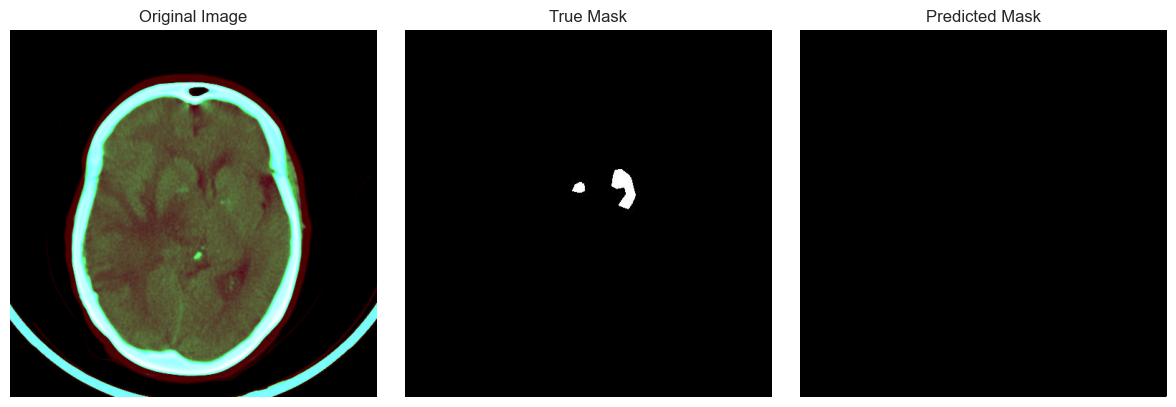

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


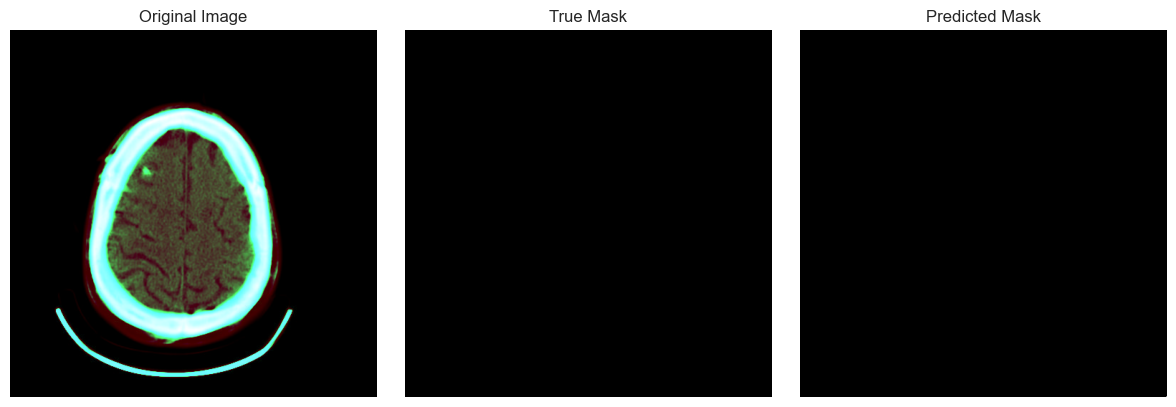

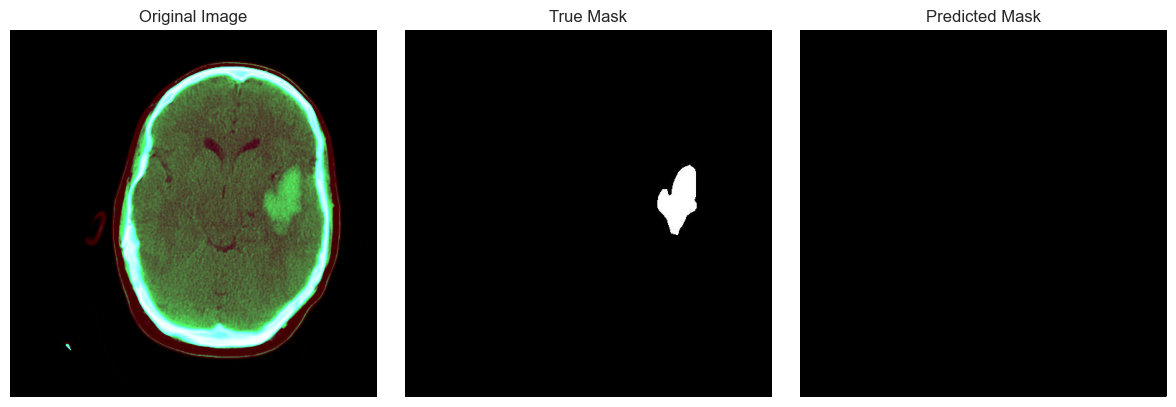

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


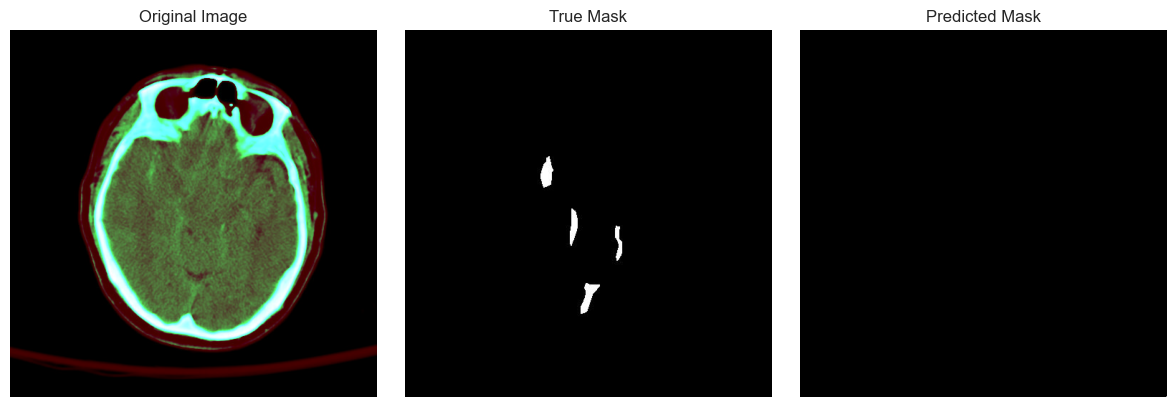

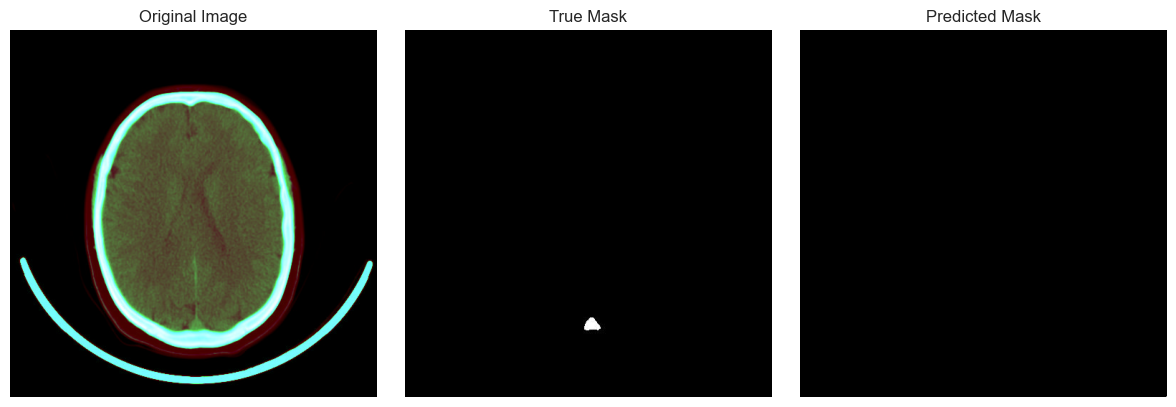

In [62]:
show_predictions_dyn(model14, test_dataset, num_batches=3, num_in_batch=2)

In [73]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model15 = build_enhanced_unet(input_shape)

# Compile the model15
model15.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model15
# model15.summary()

# Train the model15
history = model15.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model15.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.5723 - loss: 0.9673 - precision_1: 0.0321 - recall_1: 0.9526

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1200s 1s/step - accuracy: 0.5724 - loss: 0.9673 - precision_1: 0.0321 - recall_1: 0.9526 - val_accuracy: 0.8623 - val_loss: 0.9672 - val_precision_1: 0.0754 - val_recall_1: 0.8435 - learning_rate: 0.0010
Epoch 2/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1206s 1s/step - accuracy: 0.8266 - loss: 0.9677 - precision_1: 0.0641 - recall_1: 0.9174 - val_accuracy: 0.8095 - val_loss: 0.9679 - val_precision_1: 0.0559 - val_recall_1: 0.8842 - learning_rate: 0.0010
Epoch 3/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1203s 1s/step - accuracy: 0.7894 - loss: 0.9681 - precision_1: 0.0536 - recall_1: 0.9318 - val_accuracy: 0.7801 - val_loss: 0.9682 - val_precision_1: 0.0517 - val_recall_1: 0.9508 - learning_rate: 0.0010
Epoch 4/5
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1214s 1s/step - accuracy: 0.7815 - loss: 0.9668 - precision_1: 0.0538 - recall_1: 0.9449 - val_accuracy: 0.8757 - val_loss: 0.9691 - val_precision_1: 0.0778 - val_recall_1: 0.8299 - learning_rate: 0.0010
Epoch 5/5
1160/1160 ━━━━━━━━━━

In [74]:
model15.load_weights('best_model15.h5')
test_loss, test_acc, test_prec, test_recall = model15.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 91s 261ms/step - accuracy: 0.8769 - loss: 0.9659 - precision_1: 0.0899 - recall_1: 0.8945
Test Accuracy: 0.8716, Precision: 0.0789, Recall: 0.9027


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
[0.5        0.50000006 0.5000001  ... 0.7310584  0.7310585  0.73105854]
[0. 1.]


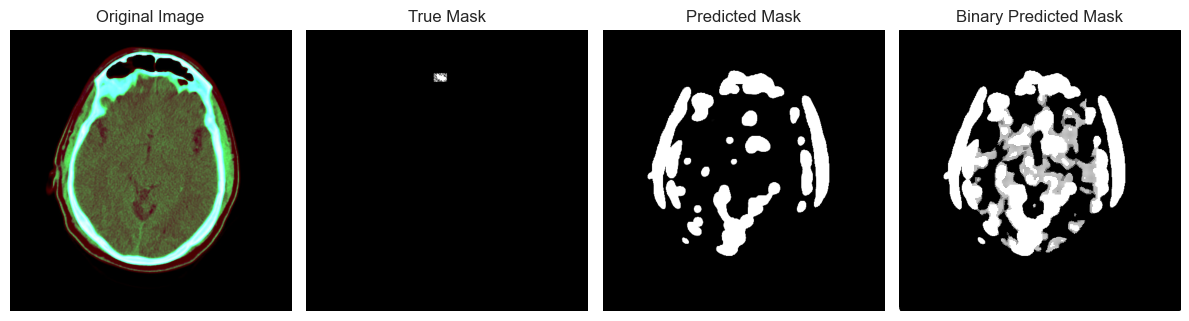

[0.5        0.50000006 0.5000001  ... 0.7310584  0.7310585  0.73105854]
[0. 1.]


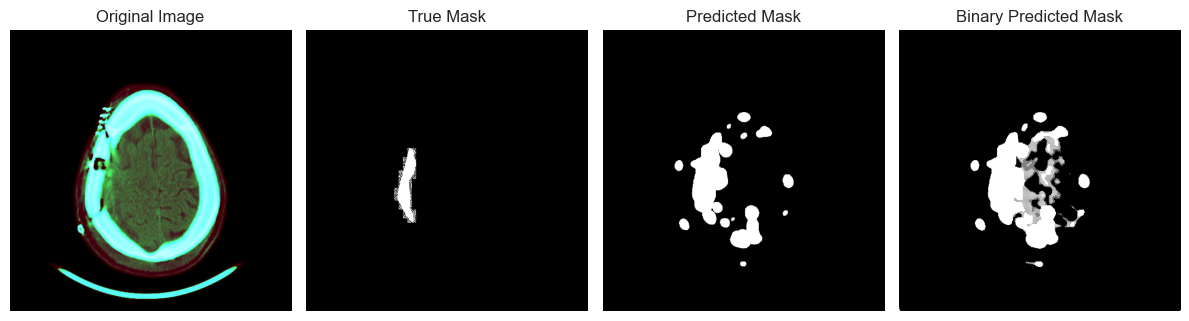

In [77]:
show_predictions_dyn_var(model15, test_dataset, num_batches=2, num_in_batch=2, threshold=0.5)

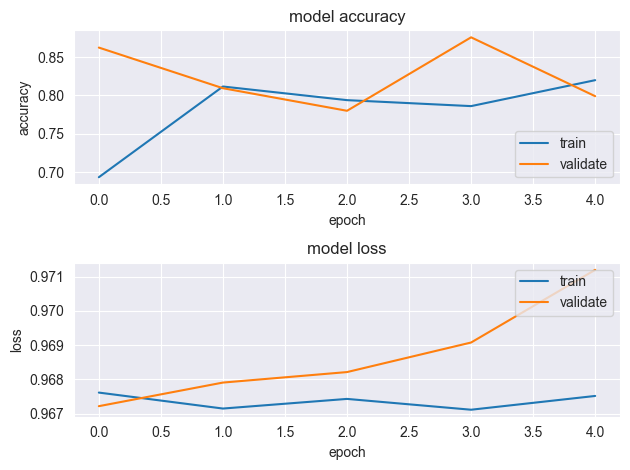

In [78]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [80]:
# Define the input shape for your U-Net model
input_shape = (512, 512, 3)

# Create the model
model16 = build_enhanced_unet(input_shape)

# Compile the model16
model16.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Print a summary of the model16
# model16.summary()

# Train the model16
history = model16.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_model16.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3,
            monitor='val_loss'
        )
    ]
)

Epoch 1/3
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.9682 - loss: 1.6714 - precision_3: 0.0130 - recall_3: 0.0190

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1185s 1s/step - accuracy: 0.9682 - loss: 1.6714 - precision_3: 0.0130 - recall_3: 0.0190 - val_accuracy: 0.9873 - val_loss: 1.6688 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/3
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1240s 1s/step - accuracy: 0.9867 - loss: 1.6678 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9881 - val_loss: 1.6703 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/3
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.9869 - loss: 1.6680 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1227s 1s/step - accuracy: 0.9869 - loss: 1.6680 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.9867 - val_loss: 1.6680 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010


In [81]:
model16.load_weights('best_model16.h5')
test_loss, test_acc, test_prec, test_recall = model16.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_recall:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 97s 274ms/step - accuracy: 0.9872 - loss: 1.6686 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Test Accuracy: 0.9881, Precision: 0.0000, Recall: 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.5]
[0. 1.]


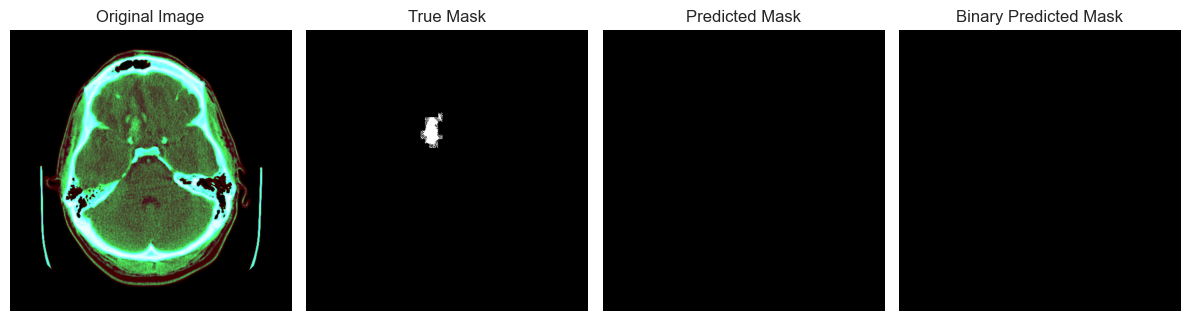

[0.5]
[0. 1.]


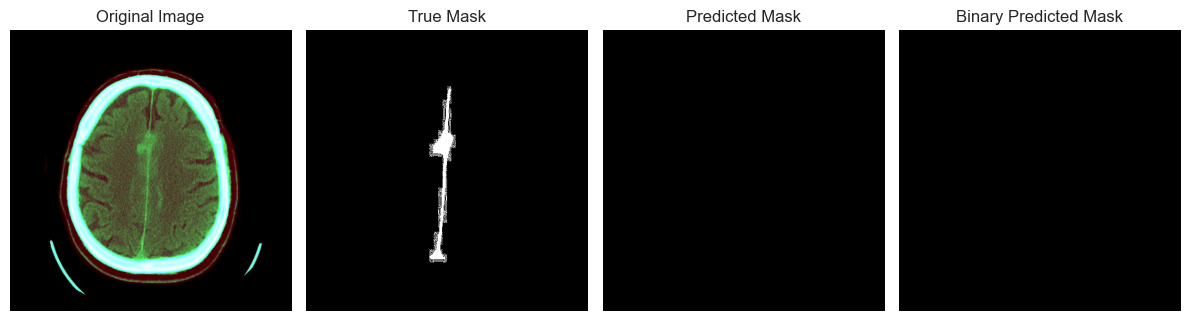

In [82]:
show_predictions_dyn_var(model16, test_dataset, num_batches=2, num_in_batch=2, threshold=0.5)

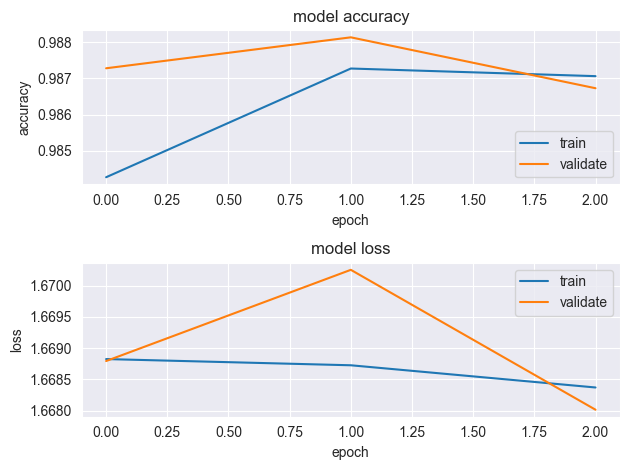

In [83]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()
